In [5]:
%reload_ext autoreload
%autoreload 3

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=False)
mpl.rc('font', family='serif', size=12)

import numpy as np
from IPython.display import display

import torch
import torchmetrics
import pytorch_lightning as pl
import pandas as pd
from src.cogponder import CogPonderModel
from src.cogponder.data import StroopSRODataset, CogPonderDataModule
from pathlib import Path

In [6]:
# this notebook only fits one SRO subject, which its SRO-SubjectID can be defined here

# upon successful training, the model will be saved to this path
# CHECKPOINT_PATH = Path('models/stroop/') / f'cogponder_subject-{SRO_SUBJECT_ID}_epochs-10000.ckpt'
CHECKPOINT_PATH = Path('models/checkpoints/stroop/cogponder_epochs-107.ckpt')

In [7]:
# DEBUG

# DEBUG - Load the checkpoint

model_ckpt = CogPonderModel.load_from_checkpoint(CHECKPOINT_PATH)
model_ckpt.eval()

print('loading data module...', end='')
dataset = StroopSRODataset(n_subjects=-1, response_step_interval=20)
datamodule = CogPonderDataModule(dataset, num_workers=8)
datamodule.prepare_data()
print('Done!')

_, subject_ids, contexts, stimuli, y_true, rt_true, _ = datamodule.test_dataset[:]

with torch.no_grad():
    model_ckpt.eval()

    print('Predicting responses...', end='')
    y_steps, y_pred, p_halts, rt_pred = model_ckpt(stimuli, subject_ids, contexts)

    print('Done!')

RuntimeError: Error(s) in loading state_dict for CogPonderModel:
	Missing key(s) in state_dict: "recurrence_node.subject_embeddings.weight". 
	Unexpected key(s) in state_dict: "subject_embeddings.weight". 

In [ ]:
human_stats = pd.DataFrame({
    'condition': contexts,
    'subject': subject_ids,
    'response_time': rt_true * dataset.response_step_interval,
    'accuracy': (stimuli[:,0] == y_true).float() * 100,
    'agent': 'Human data',
})

cogponder_stats = pd.DataFrame({
    'condition': contexts,
    'subject': subject_ids,
    'response_time': (rt_pred * dataset.response_step_interval).float(),
    'accuracy': (stimuli[:,0] == y_pred).float() * 100,
    'agent': 'CogPonder agent',
})

cogponder_stats['condition'] = cogponder_stats['condition'].map({0: 'Incongruent', 1: 'Congruent'})
human_stats['condition'] = human_stats['condition'].map({0: 'Incongruent', 1: 'Congruent'})

stats = pd.concat([human_stats, cogponder_stats]).reset_index()

mean_accuracy = stats.groupby(['agent', 'condition'])['accuracy'].mean()
median_rt = stats.groupby(['agent', 'condition'])['response_time'].median()

median_rt, mean_accuracy

(agent            condition  
 CogPonder agent  Congruent      700.0
                  Incongruent    700.0
 Human data       Congruent      640.0
                  Incongruent    760.0
 Name: response_time, dtype: float32,
 agent            condition  
 CogPonder agent  Congruent      99.008072
                  Incongruent    58.163265
 Human data       Congruent      98.117012
                  Incongruent    93.503403
 Name: accuracy, dtype: float32)

In [4]:
plot_data = stats.melt(
    id_vars=['condition', 'agent'],
    value_vars=['response_time', 'accuracy'],
    var_name='measure'
)

g = sns.catplot(
    data=plot_data, x='condition', y='value', col='measure', hue='agent',
    kind="bar", height=3, aspect=1.2,
    width=.3, errorbar=('ci', 95), capsize=.065, errwidth=1,
    palette='Set2',
    sharex=False, sharey=False,
    estimator='mean',
    col_order=['accuracy', 'response_time'],
    hue_order=['Human data', 'CogPonder agent'],
    order=['Congruent', 'Incongruent'],
    legend=False
)

g.add_legend(loc='upper left', bbox_to_anchor=(.95, .8))

g.axes[0,0].set_ylabel('% correct')
g.axes[0,0].set_title('Accuracy')
g.axes[0,1].set_ylabel('seconds')
g.axes[0,1].set_title('Response Time (s)')
g.axes[0,0].set_xlabel(None)
g.axes[0,1].set_xlabel(None)


plt.suptitle('Comparing human and CogPonder performance in the Stroop task', y=1)
plt.tight_layout()
plt.savefig('outputs/figures/figure3-stroop.png', bbox_inches='tight', dpi=300)
plt.show()

NameError: name 'stats' is not defined

In [35]:


average_human_performance = pd.DataFrame({
    'condition': -1,
    'response_time': rt_true * dataset.response_step_interval,
    'accuracy': (stimuli[:,0] == y_true).float() * 100,
    'agent': 'Human data',
})

human_performance = pd.DataFrame({
    'condition': contexts,
    'response_time': rt_true * dataset.response_step_interval,
    'accuracy': (stimuli[:,0] == y_true).float() * 100,
    'agent': 'Human data',
})

cogponder_performance = pd.DataFrame({
    'condition': contexts,
    'response_time': rt_pred * dataset.response_step_interval,
    'accuracy': (stimuli[:,0] == y_pred).float() * 100,
    'agent': 'CogPonder agent'
})

average_cogponder_performance = pd.DataFrame({
    'condition': -1,
    'response_time': rt_pred * dataset.response_step_interval,
    'accuracy': (stimuli[:,0] == y_pred).float() * 100,
    'agent': 'CogPonder agent',
})

plot_data = pd.concat([human_performance, average_human_performance,
                       cogponder_performance, average_cogponder_performance]).reset_index()

plot_data['condition'] = plot_data['condition'].map({-1: 'All', 0: 'Incongruent', 1: 'Congruent'})

plot_data = plot_data.melt(id_vars=['condition', 'agent'],
               value_vars=['response_time', 'accuracy'],
               var_name='measure'
               )

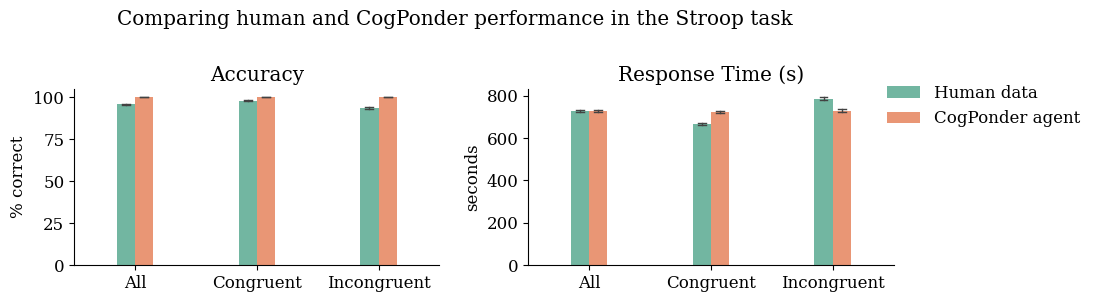

In [36]:
g = sns.catplot(
    data=plot_data, x='condition', y='value', col='measure', hue='agent',
    kind="bar", height=3, aspect=1.2,
    width=.3, errorbar=('ci', 95), capsize=.065, errwidth=1,
    palette='Set2',
    sharex=False, sharey=False,
    estimator='mean',
    col_order=['accuracy', 'response_time'],
    hue_order=['Human data', 'CogPonder agent'],
    order=['All', 'Congruent', 'Incongruent'],
    legend=False
)

g.add_legend(loc='upper left', bbox_to_anchor=(.95, .8))

g.axes[0,0].set_ylabel('% correct')
g.axes[0,0].set_title('Accuracy')
g.axes[0,1].set_ylabel('seconds')
g.axes[0,1].set_title('Response Time (s)')
g.axes[0,0].set_xlabel(None)
g.axes[0,1].set_xlabel(None)


plt.suptitle('Comparing human and CogPonder performance in the Stroop task', y=1)
plt.tight_layout()
plt.savefig('outputs/figures/figure3-stroop.png', bbox_inches='tight', dpi=300)
plt.show()

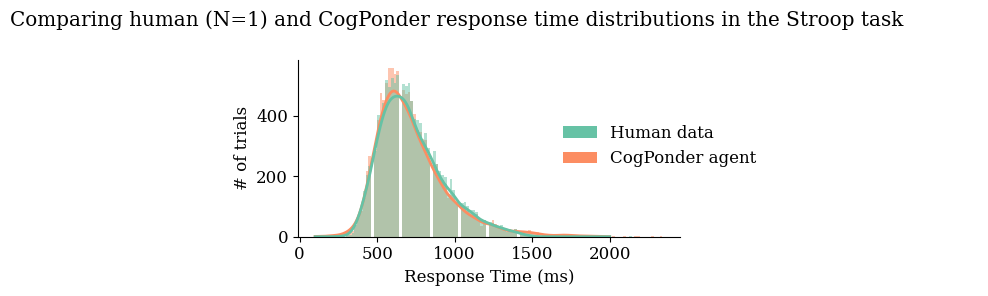

In [27]:
# Figure 4

plot_data = pd.DataFrame({
    'rt_true': rt_true * dataset.response_step_interval,
    'rt_pred': rt_pred * dataset.response_step_interval,
}).melt()

g = sns.displot(
    data=plot_data, x='value', hue='variable',
    kind='hist', kde=True, fill=True, common_norm=False,
    lw=0, alpha=.5, height=3, aspect=1.2,
    kde_kws={'cut': 0, 'clip': (0, 2000)},
    line_kws={'linewidth': 2},
    palette='Set2',
    hue_order=['rt_true', 'rt_pred'],
    legend=True
)

# replace labels
g._legend.set_title(None)
g.legend.set_bbox_to_anchor((1.6, .5))
for t, l in zip(g._legend.texts, ['Human data', 'CogPonder agent']):
    t.set_text(l)

g._legend.legend_handles[0].set_alpha(1)
g._legend.legend_handles[1].set_alpha(1)

g.ax.set(xlabel='Response Time (ms)', ylabel='# of trials')

plt.suptitle('Comparing human (N=1) and CogPonder response time distributions in the Stroop task')
plt.tight_layout()
plt.savefig('outputs/figures/figure4-stroop.png', bbox_inches='tight', dpi=300)
plt.show()